In [ ]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np # Sering berguna, meskipun tidak semua bagian menggunakannya secara eksplisit
from sklearn.preprocessing import StandardScaler, LabelEncoder # Untuk normalisasi dan encoding
from sklearn.cluster import KMeans # Algoritma K-Means
from sklearn.metrics import silhouette_score # Untuk evaluasi cluster
import matplotlib.pyplot as plt # Untuk membuat plot/grafik
import seaborn as sns # Untuk visualisasi data yang lebih menarik
import joblib
# Load the dataset
#Load Data
df = pd.read_csv('cyberData.csv')
df.head()



,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected
0,SID_00001,599,TCP,4,492.983263,DES,0.606818,1,Edge,0,1
1,SID_00002,472,TCP,3,1557.996461,DES,0.301569,0,Firefox,0,0
2,SID_00003,629,TCP,3,75.044262,DES,0.739164,2,Chrome,0,1
3,SID_00004,804,UDP,4,601.248835,DES,0.123267,0,Unknown,0,1
4,SID_00005,453,TCP,5,532.540888,AES,0.054874,1,Firefox,0,0


In [ ]:
#Identifikasi data
df.info() #Memeriksa Tipe Data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   session_id           9537 non-null   object 
 1   network_packet_size  9537 non-null   int64  
 2   protocol_type        9537 non-null   object 
 3   login_attempts       9537 non-null   int64  
 4   session_duration     9537 non-null   float64
 5   encryption_used      7571 non-null   object 
 6   ip_reputation_score  9537 non-null   float64
 7   failed_logins        9537 non-null   int64  
 8   browser_type         9537 non-null   object 
 9   unusual_time_access  9537 non-null   int64  
 10  attack_detected      9537 non-null   int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 819.7+ KB


In [ ]:
# Menghitung persentase duplikasi
percentage_duplicates = (df.duplicated().sum() / df.shape[0]) * 100

print("Jumlah duplikasi : ", df.duplicated().sum()) #Melihat Jumlah Duplikasi Data
print(f"Persentase duplikasi: {percentage_duplicates:.2f}%")

Jumlah duplikasi :  0
Persentase duplikasi: 0.00%


In [ ]:
df.describe() #Memeriksa Parameter Statistik

,network_packet_size,login_attempts,session_duration,ip_reputation_score,failed_logins,unusual_time_access,attack_detected
count,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000,9537.000000
mean,500.430639,4.032086,792.745312,0.331338,1.517773,0.149942,0.447101
std,198.379364,1.963012,786.560144,0.177175,1.033988,0.357034,0.497220
min,64.000000,1.000000,0.500000,0.002497,0.000000,0.000000,0.000000
25%,365.000000,3.000000,231.953006,0.191946,1.000000,0.000000,0.000000
50%,499.000000,4.000000,556.277457,0.314778,1.000000,0.000000,0.000000
75%,635.000000,5.000000,1105.380602,0.453388,2.000000,0.000000,1.000000
max,1285.000000,13.000000,7190.392213,0.924299,5.000000,1.000000,1.000000


In [ ]:
#cleaning data
df.drop_duplicates(inplace=True) #Menghapus Data Duplikat

In [ ]:
print("Jumlah Duplikasi : ", df.duplicated().sum()) #Melihat Jumlah Duplikasi Data

Jumlah Duplikasi :  0


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# 1. Hapus kolom ID yang tidak berguna untuk clustering
df_clean = df.drop(columns=["session_id", "attack_detected"])  # attack_detected untuk validasi nanti

# 2. Encoding fitur kategorikal
label_encoders = {}
categorical_cols = ["protocol_type", "encryption_used", "browser_type"]

for col in categorical_cols:
    le = LabelEncoder()
    df_clean[col] = le.fit_transform(df_clean[col])
    label_encoders[col] = le  # Simpan encoder jika nanti ingin membalikkan

# 3. Normalisasi fitur numerik
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_clean), columns=df_clean.columns)

# Tampilkan 5 baris hasil akhir
df_scaled.head()


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access
0,0.496899,-0.386226,-0.016346,-0.381125,0.365746,1.554930,-0.500779,0.063225,-0.419989
1,-0.143322,-0.386226,-0.525794,0.972960,0.365746,-0.168029,-1.467959,0.904191,-0.419989
2,0.648132,-0.386226,-0.525794,-0.912503,0.365746,2.301950,0.466400,-0.777742,-0.419989
3,1.530327,1.553444,-0.016346,-0.243473,0.365746,-1.174443,-1.467959,2.586125,-0.419989
4,-0.239103,-0.386226,0.493102,-0.330830,-0.907289,-1.560484,-0.500779,0.904191,-0.419989


In [ ]:
if 'attack_detected' in df.columns:
    y_true = df["attack_detected"].copy() # Membuat salinan kolom 'attack_detected'
else:
    y_true = None # Atau tangani sebagai error jika kolom ini penting untuk validasi

In [ ]:
# Membuat DataFrame baru untuk pemrosesan fitur, membuang kolom 'session_id' dan 'attack_detected'
df_features = df.drop(columns=["session_id", "attack_detected"], errors='ignore') # errors='ignore' agar tidak error jika kolom tidak ada


In [ ]:
# Encoding fitur kategorikal (mengubah teks menjadi angka)
label_encoders = {} # Dictionary untuk menyimpan encoder yang telah dibuat
categorical_cols = ["protocol_type", "encryption_used", "browser_type"] # Daftar kolom kategorikal
df_encoded = df_features.copy() # Bekerja pada salinan DataFrame

print("\n--- Encoding Fitur Kategorikal ---")
for col in categorical_cols:
    if col in df_encoded.columns:
        print(f"Melakukan encoding pada kolom: {col}")
        le = LabelEncoder() # Membuat objek LabelEncoder
        df_encoded[col] = le.fit_transform(df_encoded[col]) # Mengubah nilai kategorikal menjadi numerik
        label_encoders[col] = le # Menyimpan encoder untuk kemungkinan transformasi balik (inverse transform)
    else:
        print(f"Peringatan: Kolom kategorikal '{col}' tidak ditemukan dalam DataFrame.")

print("\n--- Tampilan Data Setelah Encoding ---")
print(df_encoded.head())


--- Encoding Fitur Kategorikal ---
Melakukan encoding pada kolom: protocol_type
Melakukan encoding pada kolom: encryption_used
Melakukan encoding pada kolom: browser_type

--- Tampilan Data Setelah Encoding ---
   network_packet_size  protocol_type  login_attempts  session_duration  \
0                  599              1               4        492.983263   
1                  472              1               3       1557.996461   
2                  629              1               3         75.044262   
3                  804              2               4        601.248835   
4                  453              1               5        532.540888   

   encryption_used  ip_reputation_score  failed_logins  browser_type  \
0                1             0.606818              1             1   
1                1             0.301569              0             2   
2                1             0.739164              2             0   
3                1             0.123267          

In [ ]:
# Normalisasi fitur numerik (menyamakan skala nilai)
# Identifikasi kolom numerik yang belum di-encode
numerical_cols_to_scale = df_encoded.select_dtypes(include=np.number).columns.tolist()
scaler = StandardScaler()
# Kolom yang di-feed ke scaler adalah semua kolom di df_clean
df_scaled_values = scaler.fit_transform(df_clean)
feature_names_for_model = list(df_clean.columns) # Ini adalah urutan fitur untuk scaler dan model
df_scaled = pd.DataFrame(df_scaled_values, columns=feature_names_for_model)


In [ ]:
# Hapus kolom yang baru saja di-label encode (karena sekarang numerik tapi mewakili kategori)
for cat_col in categorical_cols:
    if cat_col in numerical_cols_to_scale:
        numerical_cols_to_scale.remove(cat_col)

df_scaled = df_encoded.copy() # Bekerja pada salinan DataFrame

if numerical_cols_to_scale:
    print(f"\n--- Normalisasi Fitur Numerik: {numerical_cols_to_scale} ---")
    scaler = StandardScaler() # Membuat objek StandardScaler
    df_scaled[numerical_cols_to_scale] = scaler.fit_transform(df_scaled[numerical_cols_to_scale]) # Melakukan normalisasi
    print("\n--- Tampilan Data Setelah Normalisasi ---")
    print(df_scaled.head())
else:
    print("\nTidak ada kolom numerik yang teridentifikasi untuk normalisasi atau tersisa setelah encoding.")

print("\n--- Informasi Data Setelah Normalisasi ---")
df_scaled.info()




--- Normalisasi Fitur Numerik: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins', 'unusual_time_access'] ---

--- Tampilan Data Setelah Normalisasi ---
   network_packet_size  protocol_type  login_attempts  session_duration  \
0             0.496899              1       -0.016346         -0.381125   
1            -0.143322              1       -0.525794          0.972960   
2             0.648132              1       -0.525794         -0.912503   
3             1.530327              2       -0.016346         -0.243473   
4            -0.239103              1        0.493102         -0.330830   

   encryption_used  ip_reputation_score  failed_logins  browser_type  \
0                1             1.554930      -0.500779             1   
1                1            -0.168029      -1.467959             2   
2                1             2.301950       0.466400             0   
3                1            -1.174443      -1.467959   

In [ ]:
# --- 4. Menentukan Jumlah Cluster Optimal ---
print("\n--- Menentukan Jumlah Cluster Optimal ---")

# a) Metode Elbow
print("\nMenghitung inertia untuk Metode Elbow...")
inertia = [] # List untuk menyimpan nilai inertia
k_range = range(1, 11) # Menguji k dari 1 hingga 10

for k in k_range:
    kmeans_elbow = KMeans(n_clusters=k, random_state=42, n_init='auto') # n_init='auto' direkomendasikan
    kmeans_elbow.fit(df_scaled) # Melatih model K-Means
    inertia.append(kmeans_elbow.inertia_) # inertia_ adalah Sum of Squared Errors (SSE) dalam cluster




--- Menentukan Jumlah Cluster Optimal ---

Menghitung inertia untuk Metode Elbow...


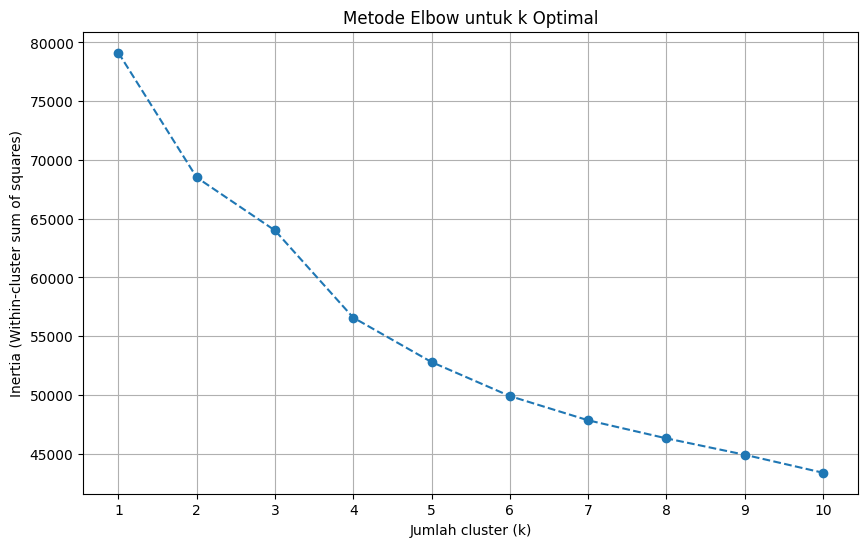

Plot Metode Elbow telah dibuat dan ditampilkan.


In [ ]:
# Membuat plot Metode Elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.xlabel('Jumlah cluster (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Metode Elbow untuk k Optimal')
plt.xticks(k_range)
plt.grid(True)
plt.show() # Menampilkan plot di notebook Colab
print("Plot Metode Elbow telah dibuat dan ditampilkan.")

In [ ]:
# b) Skor Silhouette
print("\nMenghitung Skor Silhouette...")
silhouette_scores = [] # List untuk menyimpan skor silhouette
# Skor Silhouette tidak terdefinisi untuk k=1, jadi range dimulai dari 2
k_range_silhouette = range(2, 11)

for k in k_range_silhouette:
    kmeans_silhouette = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels_silhouette = kmeans_silhouette.fit_predict(df_scaled) # Mendapatkan label cluster untuk setiap data point
    silhouette_avg = silhouette_score(df_scaled, cluster_labels_silhouette) # Menghitung skor silhouette rata-rata
    silhouette_scores.append(silhouette_avg)
    print(f"Untuk n_clusters = {k}, skor silhouette rata-rata adalah : {silhouette_avg:.4f}")




Menghitung Skor Silhouette...
Untuk n_clusters = 2, skor silhouette rata-rata adalah : 0.1567
Untuk n_clusters = 3, skor silhouette rata-rata adalah : 0.1050
Untuk n_clusters = 4, skor silhouette rata-rata adalah : 0.1231
Untuk n_clusters = 5, skor silhouette rata-rata adalah : 0.1266
Untuk n_clusters = 6, skor silhouette rata-rata adalah : 0.1199
Untuk n_clusters = 7, skor silhouette rata-rata adalah : 0.1148
Untuk n_clusters = 8, skor silhouette rata-rata adalah : 0.1101
Untuk n_clusters = 9, skor silhouette rata-rata adalah : 0.1133
Untuk n_clusters = 10, skor silhouette rata-rata adalah : 0.1095


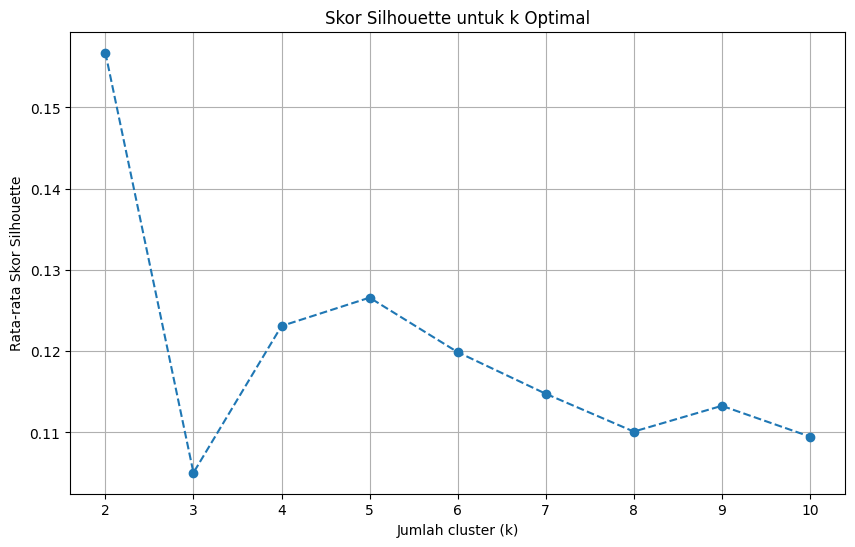

Plot Skor Silhouette telah dibuat dan ditampilkan.


In [ ]:
# Membuat plot Skor Silhouette
plt.figure(figsize=(10, 6))
plt.plot(k_range_silhouette, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Jumlah cluster (k)')
plt.ylabel('Rata-rata Skor Silhouette')
plt.title('Skor Silhouette untuk k Optimal')
plt.xticks(k_range_silhouette)
plt.grid(True)
plt.savefig("silhouette_scores.png") # Menyimpan plot
# files.download("silhouette_scores.png") # Opsional: untuk mengunduh plot
plt.show() # Menampilkan plot
print("Plot Skor Silhouette telah dibuat dan ditampilkan.")


In [ ]:
# --- 5. Menjalankan K-Means Clustering ---
# Pilih optimal_k berdasarkan plot Elbow dan Silhouette.
# Sebagai contoh, kita pilih optimal_k = 3 (sesuaikan jika perlu berdasarkan hasil plot Anda).
optimal_k = 4 # ***** PENGGUNA: Harap sesuaikan nilai ini berdasarkan plot Anda! *****
print(f"K-Means Clustering dengan k = {optimal_k} ---")

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(df_scaled)

K-Means Clustering dengan k = 4 ---


KMeans(n_clusters=4, random_state=42)

In [ ]:
# --- PENYIMPANAN MODEL DAN PREPROCESSORS ---
joblib.dump(kmeans, 'kmeans.joblib')
print("Model K-Means disimpan sebagai kmeans.joblib")

joblib.dump(scaler, 'standard_scaler.joblib')
print("StandardScaler disimpan sebagai standard_scaler.joblib")

joblib.dump(label_encoders, 'label_encoders.joblib')
print("LabelEncoders disimpan sebagai label_encoders.joblib")

joblib.dump(feature_names_for_model, 'feature_names_for_model.joblib')
print(f"Nama fitur untuk model ({len(feature_names_for_model)} fitur) disimpan sebagai feature_names_for_model.joblib: {feature_names_for_model}")

# Simpan juga daftar kolom kategorikal untuk referensi di backend
joblib.dump(categorical_cols, 'categorical_cols.joblib')
print(f"Kolom kategorikal disimpan sebagai categorical_cols.joblib: {categorical_cols}")



Model K-Means disimpan sebagai kmeans.joblib
StandardScaler disimpan sebagai standard_scaler.joblib
LabelEncoders disimpan sebagai label_encoders.joblib
Nama fitur untuk model (9 fitur) disimpan sebagai feature_names_for_model.joblib: ['network_packet_size', 'protocol_type', 'login_attempts', 'session_duration', 'encryption_used', 'ip_reputation_score', 'failed_logins', 'browser_type', 'unusual_time_access']
Kolom kategorikal disimpan sebagai categorical_cols.joblib: ['protocol_type', 'encryption_used', 'browser_type']


In [ ]:
# Menambahkan label cluster ke DataFrame yang sudah di-scaling
df_scaled['cluster'] = kmeans.fit_predict(df_scaled)

In [ ]:
# Menambahkan label cluster kembali ke DataFrame asli (df, yang sudah dibersihkan tapi belum di-scale/encode)
# Ini membantu dalam interpretasi cluster dengan nilai asli.
df['cluster'] = df_scaled['cluster'].copy() # Pastikan indeks selaras jika df_scaled dimodifikasi

print(f"Clustering K-Means selesai. Label cluster telah ditambahkan.")
print("\n--- Tampilan Awal DataFrame Asli dengan Label Cluster ---")
print(df.head())

Clustering K-Means selesai. Label cluster telah ditambahkan.

--- Tampilan Awal DataFrame Asli dengan Label Cluster ---
  session_id  network_packet_size protocol_type  login_attempts  \
0  SID_00001                  599           TCP               4   
1  SID_00002                  472           TCP               3   
2  SID_00003                  629           TCP               3   
3  SID_00004                  804           UDP               4   
4  SID_00005                  453           TCP               5   

   session_duration encryption_used  ip_reputation_score  failed_logins  \
0        492.983263             DES             0.606818              1   
1       1557.996461             DES             0.301569              0   
2         75.044262             DES             0.739164              2   
3        601.248835             DES             0.123267              0   
4        532.540888             AES             0.054874              1   

  browser_type  unusual_ti

In [ ]:
# --- 6. Menganalisis Hasil Clustering ---
print("\n--- Menganalisis Hasil Clustering ---")

# a) Ukuran cluster (jumlah anggota per cluster)
print("\nUkuran cluster:")
print(df['cluster'].value_counts().sort_index()) # Menampilkan jumlah data point di setiap cluster

# b) Centroid (titik pusat cluster, dari data yang di-scaling)
centroids_scaled = kmeans.cluster_centers_ # Mendapatkan koordinat centroid
centroids_df = pd.DataFrame(centroids_scaled, columns=df_scaled.drop(columns=['cluster']).columns)
print("\nCentroid Cluster (nilai yang sudah di-scaling):")
print(centroids_df)

# c) Menganalisis karakteristik cluster menggunakan nilai data asli jika memungkinkan
# Untuk fitur numerik (menggunakan df asli untuk interpretasi)
# Pilih kembali kolom numerik asli (sebelum scaling) untuk analisis
original_numerical_cols = []



--- Menganalisis Hasil Clustering ---

Ukuran cluster:
cluster
0    2459
1    2360
2    3352
3    1366
Name: count, dtype: int64

Centroid Cluster (nilai yang sudah di-scaling):
   network_packet_size  protocol_type  login_attempts  session_duration  \
0             0.046371       1.210655       -0.097559          0.001161   
1            -0.275166       1.216010        0.992408          0.029733   
2             0.162399       1.176962       -0.631910         -0.035633   
3            -0.006264       1.203514        0.010506          0.033932   

   encryption_used  ip_reputation_score  failed_logins  browser_type  \
0         0.722245             0.025225       0.016833      2.575844   
1         0.706904            -0.203198      -0.116939      0.304532   
2         0.716503             0.131000       0.063481      0.218144   
3         0.696193            -0.015563       0.016088      0.758419   

   unusual_time_access  
0            -0.347088  
1            -0.419989  
2        

In [ ]:
# Identifikasi kolom numerik asli dari df awal (sebelum encoding/scaling)
# Kecualikan 'attack_detected' dan kolom ID
temp_df_for_num_cols = df.drop(columns=["session_id", "attack_detected", "cluster"], errors='ignore')
for col in temp_df_for_num_cols.columns:
    if temp_df_for_num_cols[col].dtype in ['int64', 'float64'] and col not in categorical_cols:
        original_numerical_cols.append(col)

if original_numerical_cols:
    print("\nRata-rata Fitur Numerik Asli per Cluster:")
    cluster_numerical_summary = df.groupby('cluster')[original_numerical_cols].mean() # Menghitung rata-rata fitur numerik per cluster
    print(cluster_numerical_summary)
else:
    print("Tidak ada kolom numerik asli (tidak termasuk kategorikal) yang ditemukan untuk ringkasan.")




Rata-rata Fitur Numerik Asli per Cluster:
         network_packet_size  login_attempts  session_duration  \
cluster                                                          
0                 509.629118        3.840586        793.658581   
1                 446.168644        5.982203        816.343274   
2                 532.392601        2.791169        764.585089   
3                 499.188141        4.052709        819.433558   

         ip_reputation_score  failed_logins  unusual_time_access  
cluster                                                           
0                   0.335807       1.535177             0.026027  
1                   0.295600       1.396186             0.000000  
2                   0.354345       1.583831             0.000000  
3                   0.328581       1.534407             1.000000  


In [ ]:
# Untuk fitur kategorikal (menggunakan df asli dan transformasi balik nilai yang di-encode)
# Kita butuh 'df' yang berisi nilai kategorikal asli sebelum encoding, dan kolom 'cluster'
print("\nModus Fitur Kategorikal per Cluster (Label Asli):")
# Pilih hanya kolom kategorikal yang benar-benar di-encode dan ada di df
valid_categorical_cols_for_analysis = [col for col in categorical_cols if col in df.columns]

if valid_categorical_cols_for_analysis:
    # Pertama, dapatkan modus dari nilai yang di-encode dari df_encoded
    df_encoded_with_clusters = df_encoded.copy() # df_encoded memiliki nilai kategorikal yang sudah di-encode numerik
    df_encoded_with_clusters['cluster'] = df['cluster'].values # Selaraskan cluster (pastikan panjang dan urutan sama)

    # Kelompokkan berdasarkan cluster dan temukan modus kolom kategorikal yang di-encode
    # Menggunakan .agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan) untuk menangani modus yang mungkin kosong
    cluster_categorical_mode_encoded = df_encoded_with_clusters.groupby('cluster')[categorical_cols].agg(lambda x: x.mode()[0] if not x.mode().empty else np.nan)
# Lakukan transformasi balik untuk mendapatkan label asli
    cluster_categorical_summary_original_labels = cluster_categorical_mode_encoded.copy()
    for col in categorical_cols:
        if col in label_encoders and col in cluster_categorical_summary_original_labels.columns:
            # Pastikan modus bukan NaN sebelum mencoba inverse_transform
            valid_modes = cluster_categorical_summary_original_labels[col].dropna().astype(int)
            if not valid_modes.empty:
                 original_labels = label_encoders[col].inverse_transform(valid_modes) # Mengubah angka kembali menjadi teks
                 # Petakan kembali, tangani potensi ketidaksesuaian indeks jika beberapa cluster memiliki modus NaN
                 original_series = pd.Series(original_labels, index=valid_modes.index)
                 cluster_categorical_summary_original_labels[col] = original_series
            else:
                cluster_categorical_summary_original_labels[col] = np.nan # Set menjadi NaN jika semua modus adalah NaN
    print(cluster_categorical_summary_original_labels)

else:
    print("Tidak ada kolom kategorikal yang valid untuk ringkasan, atau tidak ada di DataFrame asli seperti yang diharapkan.")



Modus Fitur Kategorikal per Cluster (Label Asli):
        protocol_type encryption_used browser_type
cluster                                           
0                 TCP             AES      Firefox
1                 TCP             AES       Chrome
2                 TCP             AES       Chrome
3                 TCP             AES       Chrome



--- Crosstab: Cluster vs. Attack Detected ---
attack_detected     0     1
cluster                    
0                1308  1151
1                1163  1197
2                2045  1307
3                 757   609


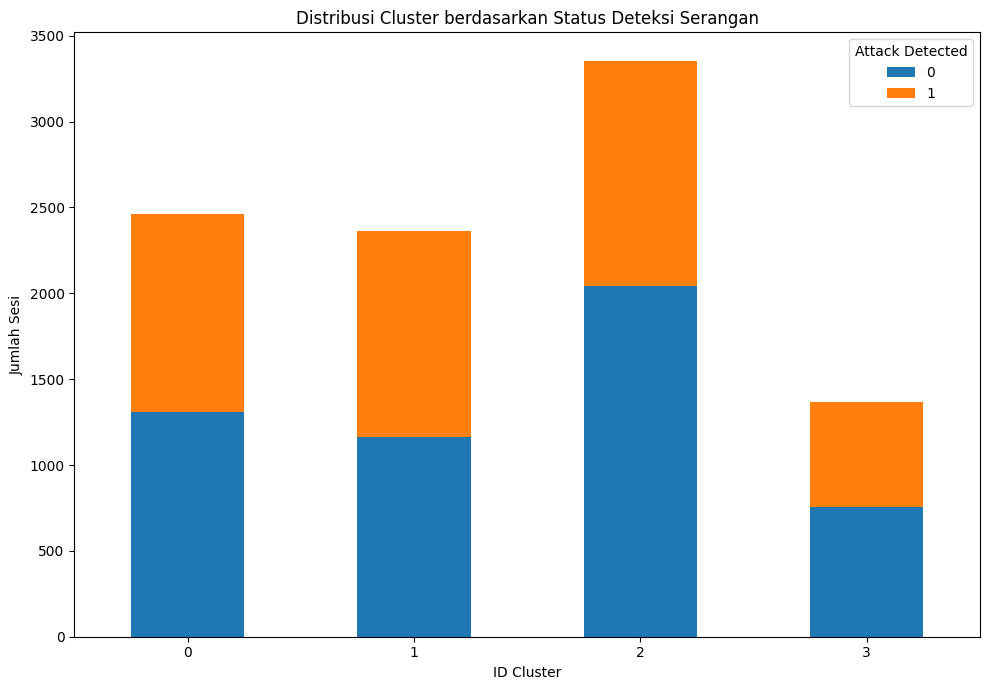

Plot crosstab 'cluster_vs_attack.png' telah dibuat dan ditampilkan.


In [ ]:
# d) Hubungan dengan 'attack_detected' (jika tersedia)
if y_true is not None and 'attack_detected' in df.columns: # Periksa apakah y_true ada isinya
    print("\n--- Crosstab: Cluster vs. Attack Detected ---")
    attack_crosstab = pd.crosstab(df['cluster'], df['attack_detected']) # Membuat tabel silang
    print(attack_crosstab)
 # Membuat plot hubungan
    attack_crosstab.plot(kind='bar', stacked=True, figsize=(10,7))
    plt.title('Distribusi Cluster berdasarkan Status Deteksi Serangan')
    plt.xlabel('ID Cluster')
    plt.ylabel('Jumlah Sesi')
    plt.xticks(rotation=0) # Agar label sumbu x tidak miring
    plt.legend(title='Attack Detected')
    plt.tight_layout()
    plt.show() # Menampilkan plot
    print("Plot crosstab 'cluster_vs_attack.png' telah dibuat dan ditampilkan.")
else:
    print("\nKolom 'attack_detected' tidak ditemukan atau tidak diproses untuk validasi eksternal.")

In [ ]:
# --- 7. Menyimpan DataFrame dengan Penugasan Cluster ---
nama_file_output = "cyberData_clustered.csv"
df.to_csv(nama_file_output, index=False) # Menyimpan DataFrame ke file CSV, index=False agar indeks DataFrame tidak ikut disimpan
print(f"\nDataFrame dengan penugasan cluster disimpan ke '{nama_file_output}'.")



DataFrame dengan penugasan cluster disimpan ke 'cyberData_clustered.csv'.
